In [ ]:
!pip install segmentation_models_pytorch
!git clone https://github.com/Bjarten/early-stopping-pytorch.git
!mv early-stopping-pytorch tools

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import os
import glob
import cv2
import datetime
import random
import pandas as pd
import time
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, TensorDataset
from segmentation_models_pytorch.utils.train import TrainEpoch
from segmentation_models_pytorch.utils.train import ValidEpoch
from segmentation_models_pytorch.utils.metrics import IoU
from segmentation_models_pytorch.utils.losses import DiceLoss
from torch.optim import *
from tools.pytorchtools import *
from torch.optim import lr_scheduler
import torchvision

In [ ]:
tif_path = "../input/ultrasound-nerve-segmentation/train"

X = []
Y = []
for root, _, files in os.walk(tif_path):
    id = 0
    for f in files:
        if f.split("_")[-1] == "mask.tif":
            continue
        else:
            X.append(f)
            Y.append(f.split(".")[0]+"_mask.tif" )
            id+=1

ids = list(range(len(X)))

train_ids = random.sample(ids, int(len(ids)*0.7))
val_and_test_ids = [i for i in ids if i not in train_ids]
valid_ids = random.sample(val_and_test_ids, int(len(val_and_test_ids)*0.5))
test_ids = [i for i in val_and_test_ids if i not in valid_ids]

train_data = {"id":train_ids,"X":[X[i] for i in train_ids],"Y":[Y[i] for i in train_ids]}
val_data = {"id":valid_ids,"X":[X[i] for i in valid_ids], "Y":[Y[i] for i in valid_ids]}
test_data = {"id":test_ids,"X":[X[i] for i in test_ids], "Y":[Y[i] for i in test_ids]}

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

train_df.to_csv("train.csv")
val_df.to_csv("val.csv")
test_df.to_csv("test.csv")

In [ ]:
class Dataset():
    def __init__(self, csv_file, root_dir, transform=None):
        self.class_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.class_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.class_frame["X"][idx])
        mask_name = os.path.join(self.root_dir, self.class_frame["Y"][idx])
        
        image = cv2.resize(cv2.imread(img_name,cv2.IMREAD_GRAYSCALE), (224,224))/255
        mask = cv2.resize(cv2.imread(mask_name,cv2.IMREAD_GRAYSCALE), (224,224))/255
        
        image = np.reshape(image, (1,224,224))
        mask = np.reshape(mask, (1,224,224))

        return (image.astype(np.float32), mask.astype(np.float32))

In [ ]:
train_dataset = Dataset("train.csv", tif_path)
valid_dataset = Dataset("val.csv", tif_path)
test_dataset = Dataset("test.csv", tif_path)

### U-Net

In [ ]:
epochs = 15

encoder = "resnet34"
encoder_wts = "imagenet"
in_channels = 1
activation = "sigmoid"

model = smp.Unet(encoder_name=encoder,activation=activation,encoder_weights=encoder_wts, in_channels=in_channels)

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
  
train_epoch = TrainEpoch(model, loss=DiceLoss(), optimizer=optimizer, metrics=[IoU(threshold=0.5)], device="cuda", verbose=True)
valid_epoch = ValidEpoch(model, loss=DiceLoss(), metrics=[IoU(threshold=0.5)], device="cuda", verbose=True)

train_losses = []
val_losses = []
train_scores = []
val_scores = []
earlyStopping = EarlyStopping(patience=4)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

for epoch in range(epochs):
    print('\nEpoch: {}'.format(epoch))
    train_res = train_epoch.run(train_loader)
    val_res = valid_epoch.run(val_loader)
    lr_scheduler.step()

    train_losses.append(train_res[DiceLoss().__name__])
    val_losses.append(val_res[DiceLoss().__name__])
    train_scores.append(train_res['iou_score']) 
    val_scores.append(val_res['iou_score'])
    
    earlyStopping(val_res[DiceLoss().__name__], model)
    if earlyStopping.early_stop:
        break
    
    lr_scheduler.step()

results = np.array([train_losses, val_losses, train_scores, val_scores])

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(results[2],'g-',lw=3, label = 'Train')
plt.plot(results[3],'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(results[0],'g-',lw=3, label = 'Train')
plt.plot(results[1],'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

In [ ]:
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [ ]:
testpath = "../input/ultrasound-nerve-segmentation/test"
imgs = [f for f in os.listdir(testpath)]
imgs = sorted( imgs, key=lambda s: int(s.split('.')[0]))
 
from tqdm.notebook import tqdm

encodings = []

for m in tqdm(imgs):
    x = cv2.imread(os.path.join(testpath, m),cv2.IMREAD_GRAYSCALE)

    x = np.reshape(cv2.resize(x,(224,224))/255 , (1,224,224)).astype(np.float32)

    x_tensor = torch.from_numpy(x).to("cuda").unsqueeze(0)
    pr_mask = model.predict(x_tensor)

    pr_mask = pr_mask.squeeze().cpu().numpy().round().astype(np.uint8)
    pr_mask = cv2.resize(pr_mask,(580,420), interpolation=cv2.INTER_CUBIC)

    encodings.append(rle_encoding(pr_mask))

In [ ]:
df_submission = pd.DataFrame(columns=["img", "pixels"])
for i, encoding in enumerate(encodings):
    pixels = ' '.join(map(str, encoding))
    df_submission.loc[i] = [str(i+1), pixels]

df_submission.to_csv('sub1.csv', index=False)

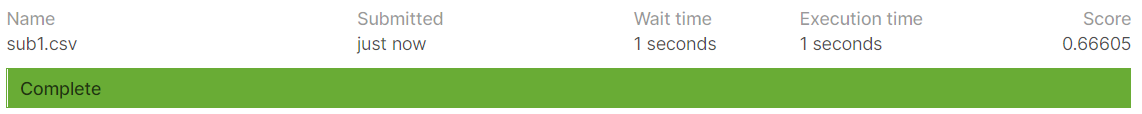

### Linknet

In [ ]:
epochs = 15

encoder = "inceptionv4"
encoder_wts = "imagenet"
encoder_depth = 15
in_channels = 1
activation = "sigmoid"

model = smp.Linknet(encoder_name=encoder,activation=activation,encoder_weights=encoder_wts, in_channels=in_channels)

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
  
train_epoch = TrainEpoch(model, loss=DiceLoss(), optimizer=optimizer, metrics=[IoU(threshold=0.5)], device="cuda", verbose=True)
valid_epoch = ValidEpoch(model, loss=DiceLoss(), metrics=[IoU(threshold=0.5)], device="cuda", verbose=True)

train_losses = []
val_losses = []
train_scores = []
val_scores = []
earlyStopping = EarlyStopping(patience=4)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

for epoch in range(epochs):
    print('\nEpoch: {}'.format(epoch))
    train_res = train_epoch.run(train_loader)
    val_res = valid_epoch.run(val_loader)
    lr_scheduler.step()

    train_losses.append(train_res[DiceLoss().__name__])
    val_losses.append(val_res[DiceLoss().__name__])
    train_scores.append(train_res['iou_score']) 
    val_scores.append(val_res['iou_score'])
    
    earlyStopping(val_res[DiceLoss().__name__], model)
    if earlyStopping.early_stop:
        break
    
    lr_scheduler.step()

results = np.array([train_losses, val_losses, train_scores, val_scores])

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(results[2],'g-',lw=3, label = 'Train')
plt.plot(results[3],'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(results[0],'g-',lw=3, label = 'Train')
plt.plot(results[1],'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

In [ ]:
testpath = "../input/ultrasound-nerve-segmentation/test"
imgs = [f for f in os.listdir(testpath)]
imgs = sorted( imgs, key=lambda s: int(s.split('.')[0]))
 
from tqdm.notebook import tqdm

encodings = []

for m in tqdm(imgs):
    x = cv2.imread(os.path.join(testpath, m),cv2.IMREAD_GRAYSCALE)

    x = np.reshape(cv2.resize(x,(224,224))/255 , (1,224,224)).astype(np.float32)

    x_tensor = torch.from_numpy(x).to("cuda").unsqueeze(0)
    pr_mask = model.predict(x_tensor)

    pr_mask = pr_mask.squeeze().cpu().numpy().round().astype(np.uint8)
    pr_mask = cv2.resize(pr_mask,(580,420), interpolation=cv2.INTER_CUBIC)

    encodings.append(rle_encoding(pr_mask))

In [ ]:
df_submission = pd.DataFrame(columns=["img", "pixels"])
for i, encoding in enumerate(encodings):
    pixels = ' '.join(map(str, encoding))
    df_submission.loc[i] = [str(i+1), pixels]

df_submission.to_csv('sub2.csv', index=False)

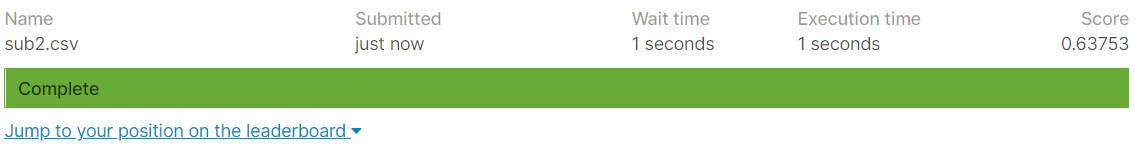

### PSPNet

In [ ]:
epochs = 15

encoder = "vgg16"
encoder_wts = "imagenet"
encoder_depth = 15
in_channels = 1
activation = "sigmoid"

model = smp.PSPNet(encoder_name=encoder,activation=activation,encoder_weights=encoder_wts, in_channels=in_channels)

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
  
train_epoch = TrainEpoch(model, loss=DiceLoss(), optimizer=optimizer, metrics=[IoU(threshold=0.5)], device="cuda", verbose=True)
valid_epoch = ValidEpoch(model, loss=DiceLoss(), metrics=[IoU(threshold=0.5)], device="cuda", verbose=True)

train_losses = []
val_losses = []
train_scores = []
val_scores = []
earlyStopping = EarlyStopping(patience=4)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

for epoch in range(epochs):
    print('\nEpoch: {}'.format(epoch))
    train_res = train_epoch.run(train_loader)
    val_res = valid_epoch.run(val_loader)
    lr_scheduler.step()

    train_losses.append(train_res[DiceLoss().__name__])
    val_losses.append(val_res[DiceLoss().__name__])
    train_scores.append(train_res['iou_score']) 
    val_scores.append(val_res['iou_score'])
    
    earlyStopping(val_res[DiceLoss().__name__], model)
    if earlyStopping.early_stop:
        break
    
    lr_scheduler.step()

results = np.array([train_losses, val_losses, train_scores, val_scores])

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(results[2],'g-',lw=3, label = 'Train')
plt.plot(results[3],'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(results[0],'g-',lw=3, label = 'Train')
plt.plot(results[1],'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

In [ ]:
testpath = "../input/ultrasound-nerve-segmentation/test"
imgs = [f for f in os.listdir(testpath)]
imgs = sorted( imgs, key=lambda s: int(s.split('.')[0]))
 
from tqdm.notebook import tqdm

encodings = []

for m in tqdm(imgs):
    x = cv2.imread(os.path.join(testpath, m),cv2.IMREAD_GRAYSCALE)

    x = np.reshape(cv2.resize(x,(224,224))/255 , (1,224,224)).astype(np.float32)

    x_tensor = torch.from_numpy(x).to("cuda").unsqueeze(0)
    pr_mask = model.predict(x_tensor)

    pr_mask = pr_mask.squeeze().cpu().numpy().round().astype(np.uint8)
    pr_mask = cv2.resize(pr_mask,(580,420), interpolation=cv2.INTER_CUBIC)

    encodings.append(rle_encoding(pr_mask))

In [ ]:
df_submission = pd.DataFrame(columns=["img", "pixels"])
for i, encoding in enumerate(encodings):
    pixels = ' '.join(map(str, encoding))
    df_submission.loc[i] = [str(i+1), pixels]

df_submission.to_csv('sub3.csv', index=False)

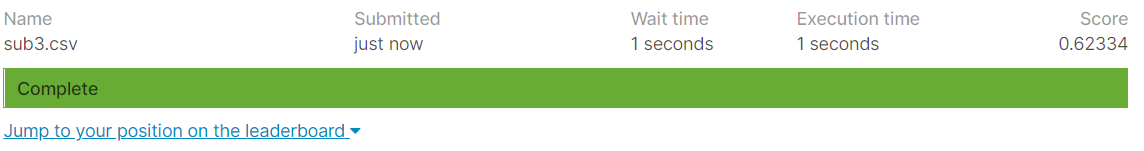

### PAN

In [ ]:
epochs = 15

encoder = "resnet34"
encoder_wts = "imagenet"
in_channels = 1
activation = "sigmoid"

model = smp.PAN(encoder_name=encoder,activation=activation,encoder_weights=encoder_wts, in_channels=in_channels)

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
  
train_epoch = TrainEpoch(model, loss=DiceLoss(), optimizer=optimizer, metrics=[IoU(threshold=0.5)], device="cuda", verbose=True)
valid_epoch = ValidEpoch(model, loss=DiceLoss(), metrics=[IoU(threshold=0.5)], device="cuda", verbose=True)

train_losses = []
val_losses = []
train_scores = []
val_scores = []
earlyStopping = EarlyStopping(patience=4)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

for epoch in range(epochs):
    print('\nEpoch: {}'.format(epoch))
    train_res = train_epoch.run(train_loader)
    val_res = valid_epoch.run(val_loader)
    lr_scheduler.step()

    train_losses.append(train_res[DiceLoss().__name__])
    val_losses.append(val_res[DiceLoss().__name__])
    train_scores.append(train_res['iou_score']) 
    val_scores.append(val_res['iou_score'])
    
    earlyStopping(val_res[DiceLoss().__name__], model)
    if earlyStopping.early_stop:
        break
    
    lr_scheduler.step()

results = np.array([train_losses, val_losses, train_scores, val_scores])

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(results[2],'g-',lw=3, label = 'Train')
plt.plot(results[3],'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(results[0],'g-',lw=3, label = 'Train')
plt.plot(results[1],'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

In [ ]:
testpath = "../input/ultrasound-nerve-segmentation/test"
imgs = [f for f in os.listdir(testpath)]
imgs = sorted( imgs, key=lambda s: int(s.split('.')[0]))
 
from tqdm.notebook import tqdm

encodings = []

for m in tqdm(imgs):
    x = cv2.imread(os.path.join(testpath, m),cv2.IMREAD_GRAYSCALE)

    x = np.reshape(cv2.resize(x,(224,224))/255 , (1,224,224)).astype(np.float32)

    x_tensor = torch.from_numpy(x).to("cuda").unsqueeze(0)
    pr_mask = model.predict(x_tensor)

    pr_mask = pr_mask.squeeze().cpu().numpy().round().astype(np.uint8)
    pr_mask = cv2.resize(pr_mask,(580,420), interpolation=cv2.INTER_CUBIC)

    encodings.append(rle_encoding(pr_mask))

In [ ]:
df_submission = pd.DataFrame(columns=["img", "pixels"])
for i, encoding in enumerate(encodings):
    pixels = ' '.join(map(str, encoding))
    df_submission.loc[i] = [str(i+1), pixels]

df_submission.to_csv('sub4.csv', index=False)

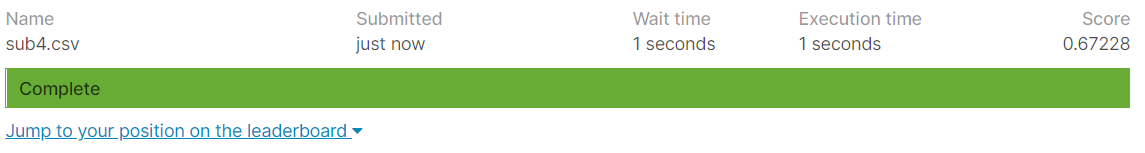

### FPN

In [ ]:
epochs = 15

encoder = "vgg16"
encoder_wts = "imagenet"
in_channels = 1
activation = "sigmoid"

model = smp.FPN(encoder_name=encoder,activation=activation,encoder_weights=encoder_wts, in_channels=in_channels)

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
  
train_epoch = TrainEpoch(model, loss=DiceLoss(), optimizer=optimizer, metrics=[IoU(threshold=0.5)], device="cuda", verbose=True)
valid_epoch = ValidEpoch(model, loss=DiceLoss(), metrics=[IoU(threshold=0.5)], device="cuda", verbose=True)

train_losses = []
val_losses = []
train_scores = []
val_scores = []
earlyStopping = EarlyStopping(patience=4)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

for epoch in range(epochs):
    print('\nEpoch: {}'.format(epoch))
    train_res = train_epoch.run(train_loader)
    val_res = valid_epoch.run(val_loader)
    lr_scheduler.step()

    train_losses.append(train_res[DiceLoss().__name__])
    val_losses.append(val_res[DiceLoss().__name__])
    train_scores.append(train_res['iou_score']) 
    val_scores.append(val_res['iou_score'])
    
    earlyStopping(val_res[DiceLoss().__name__], model)
    if earlyStopping.early_stop:
        break
    
    lr_scheduler.step()

results = np.array([train_losses, val_losses, train_scores, val_scores])

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(results[2],'g-',lw=3, label = 'Train')
plt.plot(results[3],'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(results[0],'g-',lw=3, label = 'Train')
plt.plot(results[1],'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

In [ ]:
testpath = "../input/ultrasound-nerve-segmentation/test"
imgs = [f for f in os.listdir(testpath)]
imgs = sorted( imgs, key=lambda s: int(s.split('.')[0]))
 
from tqdm.notebook import tqdm

encodings = []

for m in tqdm(imgs):
    x = cv2.imread(os.path.join(testpath, m),cv2.IMREAD_GRAYSCALE)

    x = np.reshape(cv2.resize(x,(224,224))/255 , (1,224,224)).astype(np.float32)

    x_tensor = torch.from_numpy(x).to("cuda").unsqueeze(0)
    pr_mask = model.predict(x_tensor)

    pr_mask = pr_mask.squeeze().cpu().numpy().round().astype(np.uint8)
    pr_mask = cv2.resize(pr_mask,(580,420), interpolation=cv2.INTER_CUBIC)

    encodings.append(rle_encoding(pr_mask))

In [ ]:
df_submission = pd.DataFrame(columns=["img", "pixels"])
for i, encoding in enumerate(encodings):
    pixels = ' '.join(map(str, encoding))
    df_submission.loc[i] = [str(i+1), pixels]

df_submission.to_csv('sub5.csv', index=False)

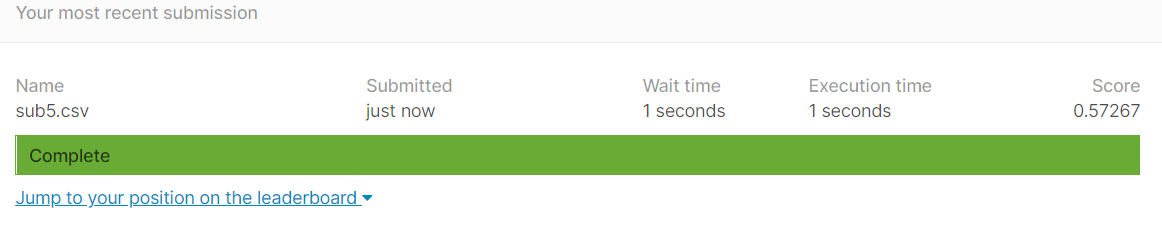